# Battery temperature evolution and prediction during drive events. 

From [previous studies](https://eclever.atlassian.net/wiki/spaces/DEV/pages/2972811265/Methodology+Training+and+storage+of+charge+curves.) we have learned that the battery temperature has important implication in the charging behavior of an electric vehicle. For instance, we have seen that even at fast charging stations, if the battery temperature is not adequate, the actual charging power could be much lower than the nominal power of the column. 
Now, let us consider the case where we want to determine the charging time of an electric vehicle that has been traveling for a while and then stops at a charging station. In order to properly estimate what will be the charging time at this charge stop it is very important to know what will be the battery temperature when the auto arrives. As one can imagine, after driving the car for a given time, the temperature of the battery will change, and this will, therefore, affect the charging process. Such considerations are extremely important for applications such as our routing algorithm, where we try to provide our users with driving and charging information that is as close as possible to reality, in order to provide the user with an enhanced experience.

In this notebook, we will try to model the temperature evolution of the battery vehicle when driving. We aim to predict with the help of machine learning what will be the battery temperature of the vehicle after driving a given distance at a given average speed given certain initial conditions for the trip. The results of this predictions can then later used to estimated what will be the charging behavior of the battery at a given charge stop.

The content of this notebook is as follows:

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-description" data-toc-modified-id="Data-description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data description</a></span></li><li><span><a href="#Data-preprocessing" data-toc-modified-id="Data-preprocessing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data preprocessing</a></span><ul class="toc-item"><li><span><a href="#Removoval-of-outliers:" data-toc-modified-id="Removoval-of-outliers:-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Removoval of outliers:</a></span></li><li><span><a href="#Correct-wrong-SoC-values" data-toc-modified-id="Correct-wrong-SoC-values-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Correct wrong SoC values</a></span></li><li><span><a href="#Imputation-of-missing-air-temperature-values" data-toc-modified-id="Imputation-of-missing-air-temperature-values-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Imputation of missing air temperature values</a></span></li><li><span><a href="#Other-preprocessing:" data-toc-modified-id="Other-preprocessing:-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Other preprocessing:</a></span></li></ul></li><li><span><a href="#Model-selection" data-toc-modified-id="Model-selection-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model selection</a></span><ul class="toc-item"><li><span><a href="#Final-model" data-toc-modified-id="Final-model-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Final model</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></li><li><span><a href="#Appendix" data-toc-modified-id="Appendix-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Appendix</a></span></li></ul></div>

In [1]:
import warnings
warnings.filterwarnings('ignore')
import importlib.util
import sys
path = '/home/jehamann/eClever/repositories/battery-temp-trainer/src/'
sys.path.append(path)

spec = importlib.util.spec_from_file_location("config", path+"config.py")
module = importlib.util.module_from_spec(spec)
sys.modules['config'] = module
spec.loader.exec_module(module)

# from IPython.display import display, Markdown, Latex
import pandas as pd
from config import get_config
from helpers import DatabaseHelper, DataHandlerHelper
import matplotlib.pyplot as plt
import seaborn as sns

with DatabaseHelper.connect_mongodb() as mongo_conn:
    data = DatabaseHelper.query_data(mongo_conn, anonymous=False)

## Data description

The table below shows a short example of the data that will be used in this work. In the table each row contains information of a single drive event. For each drive we have collected the following information:

- timestamp: Date time of the beginning of the drive.
- delta_altitude: Altitude difference between the final and starting point of the drive in meters.
- total_distance: Total distance of the drive in km.
- air_temp: Air temperature at the beginning of the drive in °C.
- soc_i: SoC of the battery at the beginning of the drive in %.
- battery_temp_i: Battery temperature at the begining of the drive in °C.
- battery_temp_f: Battery temperature at the end of the drive in °C.
- vehiclevariant_id: eClever vehiclevariant identifier.
- consumptioncurvegroup_id: eClever consumption curve group identifier.

The target value to predict will be the *battery_temp_f*, whereas the other parameters will be used as feature values for the learning model.

In [2]:
data.head()

timestamp  delta_altitude  speed_av  total_distance  total_time  \
0 2021-07-14 10:28:20             -35        33             3.3    0.140556   
1 2021-07-14 10:48:49              77        55            11.6    0.226111   
2 2021-07-15 07:19:00            -248       107            85.1    0.795000   
3 2021-07-15 08:12:19             160       102           119.2    1.217222   
4 2021-07-15 10:37:25             114        95           175.1    1.931944   

   air_temp  soc_i  battery_temp_i  battery_temp_f  odometer  \
0      17.0  100.0            20.0            20.0     352.0   
1      18.0  100.0            20.0            20.0     356.0   
2      16.0   82.5            22.0            26.0     435.0   
3      18.0   59.5            26.0            31.0     521.0   
4      18.0  100.0            31.0            30.0     640.0   

   vehiclevariant_id  consumptioncurve_id  
0              599.0                 69.0  
1              599.0                 69.0  
2              599.0                 69.0  
3              599.0                 69.0  
4              599.0                 69.0

To have a better appreciation of the data, we will have a look at some basic statistics such as value count, min, max and mean values, standard deviation so as the 25, 50 and 75 percentiles. The table below shows such statistics for our drive data. Broadly speaking, we can see that we have about 56000 drives in our dataset given by the count values. However, we see also that there are about 10000 missing values for the air_temp feature. Since this is a very important parameter, we will discuss later in the text a method to impute such missing values. 

Here we can see also that there are some strange values, for instance we see that the SoC_i has a maximum value of 120% which is obviously wrong. We see also very extreme values of delta altitude which are likely wrong data or outliers.

So the next step is to pre-process the data to get it ready for machine learning.

In [2]:
data.describe()

delta_altitude      speed_av  total_distance    total_time  \
count    56223.000000  56223.000000    56223.000000  56223.000000   
mean         0.618999     53.752948       23.673753      0.399166   
std        100.623242     21.820650       36.547566      0.407637   
min      -4977.000000      5.000000        0.000000      0.028889   
25%        -23.000000     37.000000        4.800000      0.148611   
50%          1.000000     49.000000       10.100000      0.261667   
75%         25.000000     66.000000       25.400000      0.486111   
max       1565.000000    293.000000      484.800000      5.183611   

           air_temp         soc_i  battery_temp_i  battery_temp_f  \
count  45730.000000  56223.000000    56223.000000    56223.000000   
mean      11.872906     70.137054       17.122530       17.819078   
std        8.334648     22.697048       15.783245       12.753878   
min      -40.000000      0.000000      -30.000000      -11.000000   
25%        5.000000     54.000000       10.000000       11.000000   
50%       11.000000     74.000000       16.000000       17.000000   
75%       18.000000     89.250000       22.000000       23.000000   
max       71.000000    120.000000      655.000000      655.000000   

            odometer  vehiclevariant_id  consumptioncurve_id  
count   56019.000000       56215.000000         56215.000000  
mean    15661.838091         474.027573            44.183118  
std     17204.004214          86.015881            22.586159  
min         9.000000         327.000000             2.000000  
25%      5321.500000         415.000000            24.000000  
50%     10246.000000         446.000000            50.000000  
75%     18398.000000         585.000000            66.000000  
max    117168.000000         607.000000            69.000000

## Data preprocessing

Our data preprocessing will consist of the following steps:

### Removoval of outliers:

A basic removal of outliers, this will be done by selecting the data that fall within 4 times the standard deviation from the mean so that very extreme values are removed from the data but still keeping about 99% of the data. 

### Correct wrong SoC values

In the dataset there are about 87 drives where the initial SoC is larger than 100%. We will correct these values and set them to 100. 

### Imputation of missing air temperature values
The most important step is the imputation of the missing *air_temp* values. There are about 10000 of these values which are missing. Imputing weather values cannot be done with a simple mean approach since these values are season dependent. For example using the 11°C mean value to impute air temperature values in summer or winter is probably not realistic. What we will do is to use the time information we have and generate another column which will be the calender week number *week*. We then will group the data into week and get the mean air temperature of that week. We will use this value to impute missing data.

The figure belows show the weekly averaged air temperatures used for the imputation determined as above mentioned. Here we see that these temperatures better reflect the cyclic temperature variations as given by weather seasons. The black. line shows the average temperature for the whole dataset. Off course, this approach is valid for a given location and will vary for other countries. However for this first approach where we are considering only data coming from Germany, it is OK. Once more data from other geo-locations are available we will need to reconsider this approach.

In [30]:
t_impute_table = data[["air_temp"]].copy()
t_impute_table["week"] = data.timestamp.apply(lambda x: x.week)
t_impute_table = t_impute_table.groupby("week").mean().interpolate().round()

plt.figure(figsize=(10,7))
plt.xlabel("Calendar week")
plt.ylabel("Air Temperature [°C]")
plt.plot(t_impute_table.index, t_impute_table.air_temp, 'o-')
plt.hlines(y = data.air_temp.mean(), xmin=0, xmax=55);

''

### Other preprocessing:

Additional to the above discussed data preprocessing steps, we have also done some rounding of values for the temperatures and SoC.

Also, we have added the *speed_av* column which corresponds to the average speed through all the drive. This is determined based on traveled distance and the total time it took to finished the drive. Although, this data was also obtained from the speed parameter obtained from the cPack unit, which calculates the speed based on time and GPS location, we have seen that this value was quite often different from the value calculated using the total distance and travel time. Since in our application, namely the routing algorithm, the speed is calculated using the drive time and total distance, it is important to keep the art and definition of data as close to that of the application as possible in order to ensure a proper generalization of the model.

Finally, duplicated data will be discarded.

In [32]:
def data_preprocessing(df, plot=False):

    dff = df.copy()
    
    # drop entries with no vehiclevariant_id or odometer
    dff = dff.dropna(subset=['vehiclevariant_id', 'odometer'])

    # inpute missing air temp values with mean data of calender week
    dff = add_time_features(dff)
    
    temp_dict = dff[["week", "air_temp"]].groupby("week").mean().interpolate().round().to_dict()["air_temp"]
    null_idx = dff[dff["air_temp"].isnull()].index
    dff.loc[null_idx, "air_temp"] = dff.loc[null_idx, "week"].apply(lambda x: temp_dict[x]).values

    # inpute wrong SoC values larger than 100 with 100
    soc_idx = dff[dff["soc_i"] > 100].index
    dff.loc[soc_idx, "soc_i"] = 100

    # add speed from distance and time
    dff["speed_av"] = round(dff["total_distance"] / dff["total_time"])
    
    # remove outliers
    rm_outliers_list = [
        "speed_av",
        "total_distance",
        "delta_altitude",
        "battery_temp_i",
        "battery_temp_f",
        "air_temp",
    ]

    dff = DataHandlerHelper.remove_outliers(dff, rm_outliers_list)

    # round values
    cols_to_round = ["soc_i", "battery_temp_i", "battery_temp_f", "air_temp"]
    dff = DataHandlerHelper.round_cols(dff, cols_to_round)

    # drop duplicate data
    dff = dff.drop_duplicates()

    return dff

def add_time_features(df):
    df["month"] = df["timestamp"].apply(lambda x: x.month)
    df["week"] = df["timestamp"].apply(lambda x: x.week)
    return df

data_cleaned = data_preprocessing(data)

data_cleaned.describe()

delta_altitude      speed_av  total_distance    total_time  \
count    54141.000000  54141.000000    54141.000000  54141.000000   
mean         0.622024     45.925140       20.367376      0.366703   
std         69.938342     22.639554       27.512399      0.331129   
min       -389.000000      0.000000        0.000000      0.028889   
25%        -22.000000     29.000000        4.700000      0.146944   
50%          1.000000     41.000000        9.800000      0.255278   
75%         24.000000     59.000000       23.100000      0.463333   
max        390.000000    159.000000      167.900000      2.970556   

           air_temp         soc_i  battery_temp_i  battery_temp_f  \
count  54141.000000  54141.000000    54141.000000    54141.000000   
mean      12.695277     69.815223       16.687575       17.459892   
std        7.881938     22.649073        8.406618        8.006864   
min      -14.000000      0.000000      -30.000000      -11.000000   
25%        6.000000     54.000000       10.000000       11.000000   
50%       12.000000     74.000000       16.000000       17.000000   
75%       19.000000     89.000000       22.000000       23.000000   
max       41.000000    100.000000       61.000000       49.000000   

            odometer  vehiclevariant_id  consumptioncurve_id         month  \
count   54141.000000       54141.000000         54141.000000  54141.000000   
mean    15678.031769         473.008921            44.019135      7.441089   
std     17224.334206          85.954975            22.648775      3.460595   
min         9.000000         327.000000             2.000000      1.000000   
25%      5302.000000         415.000000            24.000000      5.000000   
50%     10232.000000         446.000000            49.000000      8.000000   
75%     18465.000000         585.000000            66.000000     10.000000   
max    117168.000000         607.000000            69.000000     12.000000   

               week  
count  54141.000000  
mean      30.353540  
std       14.980823  
min        1.000000  
25%       22.000000  
50%       34.000000  
75%       42.000000  
max       52.000000

The table above shows again the descriptive statistics of the data after pre-processing. As we can see there is no missing values, all columns have the same count value. Also the SoC and delta altitude look more reasonable.

Let us now have a look at the data as histograms to have a better data visualization.

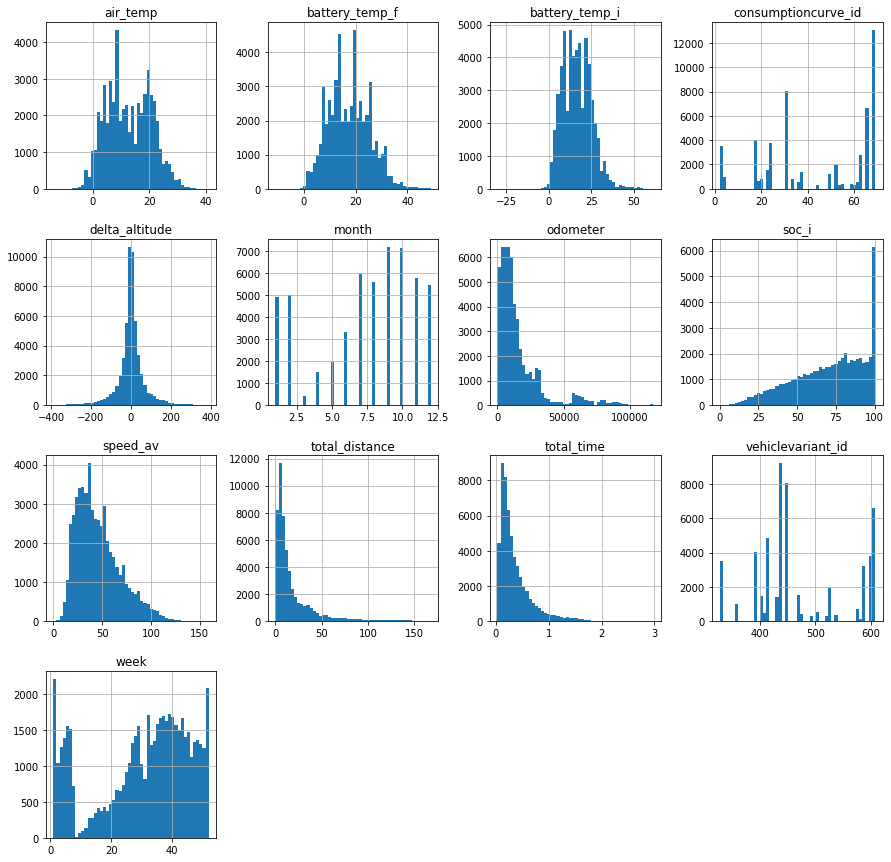

In [33]:
data_cleaned.hist(bins=50, figsize=(15,15));

The figure above show histograms of the available data. From these we can see that some values have skewed distribution such as the total distance and travel time, which as expected is also reflected in the average speed. We also see that the delta altitude shows a nice normal distribution with its center close to the zero value. The other temperature recordings show also a normal like distribution.

Let us now jump into the next step which is the machine model selection.

## Model selection

For the model selection we will proceed as we have being doing in the last projects, that is, we will split the data in a train (80%) and a validation set (20%). With the train set we will try many different regression algorithms with different standardizing/normalization procedures. These models will be trained using a 3-fold cross validation. 

Also, categorical features like *vehiclevariant_id* and *consumptioncurvegroup_id* will be encoded as one hot numeric arrays. We use one hot encoding because these ids are not ordinal, this is, there is no hierarchy or natural order that defines them. So to avoid that the model tries to assume a non existing ordering among the labels we use one hot encoding.

In [90]:
from sklearn.model_selection import (RandomizedSearchCV, train_test_split,
                                     StratifiedKFold, cross_val_score)
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import (
    SGDRegressor, Lars, LassoLars, OrthogonalMatchingPursuit, 
    ARDRegression, HuberRegressor, TheilSenRegressor, BayesianRidge,
    LinearRegression, Lasso, ElasticNet, Ridge)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor,
                              AdaBoostRegressor, ExtraTreesRegressor)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from datetime import datetime
import seaborn as sns
import numpy as np
skf = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

one_hot_encoder = OneHotEncoder(sparse=False)
def setup_models_one_hot(cat_cols, scaler=None):
    """
    creates a dict with different models to train.
    
    scaler (str): type of scaler to use to pre-process the data. 
    """
    scaler_dict = {
        "power_scaler": PowerTransformer(),
        "standard_scaler": StandardScaler(),
        "quantile_transform": QuantileTransformer(
            output_distribution='normal', random_state=42)
    }
    # algorithms to try
    model_list=[
        BayesianRidge(),
        AdaBoostRegressor(),
        SGDRegressor(random_state=42),
        LinearRegression(),
        KNeighborsRegressor(n_jobs=-1),
        MLPRegressor(random_state=42),
        SVR(),
        ARDRegression(),
        Lasso(),        
        HuberRegressor(),
        ElasticNet(),
    ]
    
    col_trans = ColumnTransformer(
    transformers=[
        ("one_hot_vehicleid",one_hot_encoder, cat_cols),
        ],
    remainder=scaler,
    )
    
    if scaler:
        model_dict = {type(model).__name__: make_pipeline(
            ColumnTransformer(
                transformers=[
                    ("one_hot_vehicleid", one_hot_encoder, cat_cols),
                    ],
                remainder=scaler_dict[scaler],
                ),
            model) for model in model_list}
    else:
        model_dict = {type(model).__name__: make_pipeline(
            ColumnTransformer(
                transformers=[
                    ("one_hot_vehicleid", one_hot_encoder, cat_cols),
                    ],
                remainder="passthrough",
                ),
            model) for model in model_list}

    return model_dict

def do_train_test_split(df, feature_cols, target_cols, stratify=None):
    """
    Creates train and test datasets.
    
    df (DataFrame): Original data
    feature_cols (list): list with names of cols in df to be used as features
    target_cols (list): list with names of cols in df to be used as target
    stratify (str): name of column use to do stratified train-test splitting
    """
    # set features and targets
    features = df[feature_cols]
    targets = df[target_cols]

    if stratify:
        stratify = df[stratify]

    return train_test_split(
        features, targets,
        stratify= stratify,
        test_size=0.2, random_state=42)

def evaluate_model(model, features, targets):
    """
    Evaluates a model and determines mae, mse and r2 metrics
    
    model (object): ML model to score
    features (DataFrame): data with features to predict
    targets (DataFrame): actual values 
    """
    predictions = model.predict(features)
    mae = mean_absolute_error(targets, predictions)
    mse = mean_squared_error(targets, predictions)
    r2 = r2_score(targets, predictions)

    return pd.DataFrame({"MAE":mae, 
                         "RMSE":np.sqrt(mse),
                         r"$r^2$": r2}, index=[0]).round(3)

def compare_model_scores_cv(models, X, y, stratify, score=None):
    """
    This function compares predictive scores from different ML algorithms
    """
    if score:
        scorer = make_scorer(score)
    else:
        scorer = "r2"

    scores = [{"model": model,
               "cv_score": cross_val_score(
                   models[model], X, y.values.ravel(), cv=skf.split(X, X[stratify]), n_jobs=-1, scoring=scorer).mean(),
             } for model in models]

    return (
        pd.DataFrame(scores)
        .set_index("model")
        .sort_values(by="cv_score")
        .round(3)
           )

def model_selector1(df, feature_cols, target_cols, cat_cols, stratify):
    tree_based_model_list=[
        GradientBoostingRegressor(random_state=42),
        RandomForestRegressor(random_state=42, n_jobs=-1),
        ExtraTreesRegressor(random_state=42, n_jobs=-1)
    ]
    
    cv_results = pd.DataFrame()
    val_results = pd.DataFrame()
    scalers = [None, "power_scaler", "standard_scaler", "quantile_transform"]
    X_train, X_test, y_train, y_test = do_train_test_split(
        df, feature_cols, target_cols, stratify)
    for scaler in scalers:
        models = setup_models_one_hot(cat_cols, scaler=scaler)
        # add tree based models
        if scaler == None:
            for model in tree_based_model_list:
                    models[type(model).__name__] = make_pipeline(
                        ColumnTransformer(
                            transformers=[
                                ("one_hot_vehicleid", one_hot_encoder, cat_cols),
                                ],
                            remainder="passthrough",
                            ),
                        model
                        ) 

        cv_scores = compare_model_scores_cv(models, X_train, y_train, stratify, score=mean_squared_error)
        cv_scores["scaler"] = scaler
        cv_results = pd.concat([cv_results, cv_scores])
        for model in models:
            base_model = models[model].fit(X_train, y_train.values.ravel())
            val_scores = evaluate_model(base_model, X_test, y_test).round(4)
            val_scores["model"] = model
            val_scores["scaler"] = scaler
            val_results = pd.concat([val_results, val_scores])

    joined_res = pd.merge(
        cv_results, val_results,  how='left', left_on=['model','scaler'], right_on = ['model','scaler']).sort_values(by="RMSE")
    joined_res["cv_score"] = np.sqrt(joined_res.cv_score)
                
    return joined_res.set_index("model")

def model_selector(df, feature_cols, target_cols, cat_cols, stratify):
    results = pd.DataFrame()
    scalers = [None, "power_scaler", "standard_scaler", "quantile_transform"]
    X_train, X_test, y_train, y_test = do_train_test_split(
        df, feature_cols, target_cols, stratify)
    for scaler in scalers:
        models = setup_models_one_hot(cat_cols, scaler=scaler)
        for model in models:
            base_model = models[model].fit(X_train, y_train)
            scores = evaluate_model(base_model, X_test, y_test).round(4)
            scores["model"] = model
            scores["scaler"] = scaler
            results = pd.concat([results, scores])
    return results.sort_values(by="RMSE")

As a first approach we will use only one of the categorical features starting with the *consumptioncurvegroup_id*. Then we will use the *vehiclevariant_id* and see if there is an advantaged on using one against the other.

In [87]:
warnings.filterwarnings("ignore")
# initial data
target_cols = [
    'battery_temp_f'    
]

feature_cols = [
#     'timestamp',
    'delta_altitude',
    'speed_av',
    'total_distance',
    'air_temp',
    'soc_i',
    'battery_temp_i',
#     'vehiclevariant_id',
    'consumptioncurve_id',
]

cat_cols = [
#    "vehiclevariant_id",
    "consumptioncurve_id",
]
selector_res_ccid  = model_selector1(
    data_cleaned, feature_cols, target_cols, cat_cols, "consumptioncurve_id")

text = "Table 1. Algorithm scores - Consumption curve ID"
print(text, "\n"+"_"*len(text))
selector_res_ccid.sort_values(by="RMSE").head(10)

Table 1. Algorithm scores - Consumption curve ID 
________________________________________________


cv_score              scaler    MAE   RMSE  $r^2$
model                                                                       
MLPRegressor               1.947049     standard_scaler  1.065  1.924  0.943
MLPRegressor               1.964943  quantile_transform  1.089  1.931  0.943
MLPRegressor               1.958826        power_scaler  1.086  1.966  0.940
MLPRegressor               2.050853                None  1.119  2.010  0.938
ExtraTreesRegressor        2.059854                None  1.101  2.022  0.937
RandomForestRegressor      2.090454                None  1.113  2.065  0.934
GradientBoostingRegressor  2.142429                None  1.165  2.106  0.932
SVR                        2.143828  quantile_transform  1.091  2.122  0.931
SVR                        2.135884        power_scaler  1.066  2.124  0.931
SVR                        2.140561     standard_scaler  1.069  2.131  0.930

The table above shows the top ten models with the best performance. This was judge based on the value of the root mean squared error (RMSE) based on the validation dataset. The table also shows the cv_score, which is the resulting RMSE score after the 3 fold cross validation. The mean absolute error (MAE) and the coefficient of determination ($r^2$)

From the table we can see that the best model is a multilayer perceptron regressor (MLPRregressor) using a standard scaler as normalization. For this model the $r^2$ has a value of 0.94, which is rather high. Remember that the best possible value is 1. Also, we see that the mean absolute error (MAE) is about 1 °C.

Now, lets try to see if by including the *vehiclevariant_id* instead of the *consumptioncurvegroup_id* yields better performance.

In [104]:
warnings.filterwarnings("ignore", message="ConvergenceWarning")
# initial data
target_cols = [
    'battery_temp_f'    
]

feature_cols = [
#     'timestamp',
    'delta_altitude',
    'speed_av',
    'total_distance',
    'air_temp',
    'soc_i',
    'battery_temp_i',
    'vehiclevariant_id',
#     'consumptioncurve_id',
]

cat_cols = [
   "vehiclevariant_id",
#     "consumptioncurve_id",
]
selector_res_vvid = model_selector1(
    data_cleaned, feature_cols, target_cols, cat_cols, "vehiclevariant_id")

text = "Table 2. Algorithm scores - Vehicle variant ID"
print(text, "\n"+"_"*len(text))
selector_res_vvid.sort_values(by="RMSE").head(10)

Table 2. Algorithm scores - Vehicle variant ID 
______________________________________________


cv_score              scaler    MAE   RMSE  $r^2$
model                                                                       
MLPRegressor               1.960867     standard_scaler  1.053  1.868  0.946
MLPRegressor               1.981666        power_scaler  1.059  1.873  0.945
MLPRegressor               1.973829  quantile_transform  1.070  1.879  0.945
MLPRegressor               2.104281                None  1.133  1.969  0.940
SVR                        2.155458        power_scaler  1.048  2.020  0.936
SVR                        2.162868  quantile_transform  1.075  2.022  0.936
GradientBoostingRegressor  2.167948                None  1.154  2.024  0.936
SVR                        2.159861     standard_scaler  1.054  2.034  0.936
ExtraTreesRegressor        2.078220                None  1.120  2.038  0.935
RandomForestRegressor      2.118962                None  1.120  2.057  0.934

/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In the table above, we see again the top ten models scores. Here again the MLPregressor with a standar scaler has the best $r^2$ score and a rather low MAE. However we see that using *vehiclevariant_id* has slightly better score values, 0.946 with respect to 0.943 as the *consumptioncurvegroup_id*. Hence, we will stick with the *vehiclevariant_id* as feature and continue with our next step which is the hyperparameter tunning and final model determination.

Here is also worth mentioned that we have tried using additional features like the odometer, month and calender week to see if the regression performance increases, but this was not the case. the results of these trials are summarized in the Appendix section at the end of the notebook.

To finish this section we can also plot the residuals between the predicted and real values of the final target (final battery temperature) in order to have a visual understanding on how good the predictions are.

In [83]:
def plot_residuals(model, x, y, hue):
    """
    Plots the residuals after prediction
    
    model (object): ML model
    x (DataFrame): data with features to predict
    y (DataFrame): actual values 
    """
    df = x.copy()
    predicted = model.predict(x)
    df["predicted"] = predicted
    df["real"] = y
    df["diff"] = y-predicted
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 2, 1)
    palette = "bright"
    sns.regplot(predicted, y, ax=ax, scatter_kws={'alpha':0.3})
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Real")
    
    ax = fig.add_subplot(1, 2, 2)
    sns.residplot("predicted", "real", data=df,ax=ax, scatter_kws={'alpha':0.3})
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Residuals")
    ax.grid(True, axis="y")
    fig.tight_layout()   

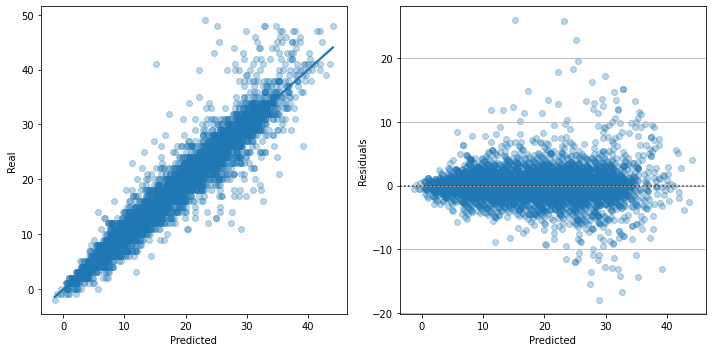

In [84]:
best_model = setup_models_one_hot(cat_cols, scaler="standard_scaler")["MLPRegressor"]

X_train, X_test, y_train, y_test = do_train_test_split(
        data_cleaned, feature_cols, target_cols, "vehiclevariant_id")

best_model.fit(X_train, y_train.values.ravel())

plt.rc('font', size=10)
plot_residuals(best_model, X_test, y_test.values.reshape(-1), hue=None);

The figure above shows the predicted values vs. the real values (left) together with the residuals plot (right). As we can see in the residuals plot, the data clusters around the zero line with the bulk of the data within 3°C to -3°C. Considering that these plots are done on the test data which consists of about 10000 drives, the results are very good.

### Final model

The hyperparameter tunning was done as we have been doing in previous projects, where we perform an Random Grid Search with k-fold cross validation. So we first search the best parameters on a large hyperparameter grid space. Then we identify regions in this space where the scorings are being improved and repeat the procedure on a smaller space until we find the best combination of parameters possible.

The whole procedure will not be shown here, we will only show the final result which is the following:

+ Estimator: MLPRregressor
+ hidden_layer_sizes: 120 
+ max_iter: 500
+ beta_1: 0.9
+ beta_2: 0.7
+ activation: "logistic"
+ random_state: 42

This model gives us a slightly better performance, which is about % better $r^2$ and a better % of MAE. 

Table . MLP. metrics before and after fine tuning.


MAE   RMSE  $r^2$
Optimization                     
before        1.053  1.868  0.946
after         1.041  1.867  0.946

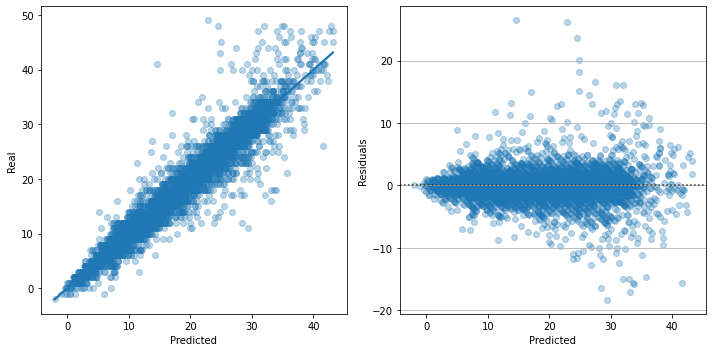

In [97]:
feature_cols = [
    'delta_altitude',
    'speed_av',
    'total_distance',
    'air_temp',
    'soc_i',
    'battery_temp_i',
    'vehiclevariant_id',
]

cat_cols = ["vehiclevariant_id"]

X_train, X_test, y_train, y_test = do_train_test_split(
        data_cleaned, feature_cols, target_cols, "vehiclevariant_id")

#final optimized regressor
estimator = MLPRegressor(
    hidden_layer_sizes=120, 
    max_iter=500,
    beta_1=0.9,
    beta_2=0.7,
    activation="logistic",
    random_state=42,
    )

col_trans = ColumnTransformer(
    transformers=[
        ("vehicleid",OneHotEncoder(sparse=False), cat_cols),
        ],
        remainder=StandardScaler(),
    )

mlp_hp_best = make_pipeline(
    col_trans,
    estimator
    )

mlp_hp_best.fit(X_train, y_train.values.ravel())

base_model = setup_models_one_hot(
    cat_cols, scaler="standard_scaler")["MLPRegressor"]
base_model.fit(X_train, y_train)

mlp_before = evaluate_model(base_model, X_test, y_test)
mlp_before["Optimization"] = "before"

mlp_after = evaluate_model(mlp_hp_best, X_test, y_test)
mlp_after["Optimization"] = "after"

plt.rc('font', size=10)
plot_residuals(mlp_hp_best, X_test, y_test.values.reshape(-1), hue=None);

print("Table . MLP. metrics before and after fine tuning.")
pd.concat([mlp_before, mlp_after]).set_index("Optimization")

The table above shows the scores of the model before and after hyperparameter tunning. We see, that after tunning, there is a slight increase in prediction performance of the model. For completeness we also show above a figure with the residuals plot of the model after tunning. 

To finalize, let us now, plot some real temperature dependent curves from drives of real e-vehicles, together with the corresponding predictions based on the model here described. 

In [27]:
def get_trip_data():
    with DatabaseHelper.connect_mongodb() as mongo_conn:
        query = [
            {
                "$match": {
                    "driveInfo.totalDriveDistance": {
                        "$gt": 60
                    },
                    "driveProfile.airTemp": {
                        "$ne": None
                    }
                },
            },
            {
                "$sample": {"size": 10},
            },
            {
                "$project": {
                    "timestamp": "$driveInfo.startTime",
                    "soc": "$driveProfile.soc",
                    "altitude": "$driveProfile.altitude",
                    "distance": "$driveProfile.distance",
                    "speed": "$driveProfile.speed",
                    "battery_temp": "$driveProfile.batteryTemp",
                    "air_temp": "$driveProfile.airTemp",
                    "time": { 
                        "$divide": [
                            {"$subtract": [
                                "$driveInfo.endTime","$driveInfo.startTime"
                                ]},
                            3600000,
                            ],
                    },
                    "vehiclevariant_id": "$vehicleVariantId",  
                    "consumptioncurve_id": "$consumptionCurveGroupId",  
                    "_id": 0,
                },
            },
        ]

        collection = mongo_conn[get_config().MONGODB_DB][get_config().MONGODB_COLLECTION_DRIVES]
        data_df = list(collection.aggregate(query))
        data_df = [pd.DataFrame(drive) for drive in data_df]

        DatabaseHelper.logger.debug(
            "DatabaseHelper - query_data() - "
            "{} Entries found.".format(len(data_df))
        )
        return data_df


def plot_check_with_real(drive, ax, model):
    test_df = pd.DataFrame({
        'altitude':drive.altitude,
        'speed':drive.speed,
        'distance': drive.distance,
        'air_temp':drive.air_temp.round(),
        'soc':drive.soc.round(),
        'time':drive.time,
        'battery_temp':drive.battery_temp.round(),
        "vehiclevariant_id": drive.vehiclevariant_id,
    })
    # ML features for each point in drive
    test_df['delta_altitude'] = test_df.altitude.diff().shift(-1)
    test_df['speed_av'] = test_df.distance.iloc[-1] / test_df.time.iloc[0]
    test_df['total_distance']=test_df.distance.diff()
    test_df['air_temp'] = test_df.air_temp
    test_df['soc_i'] = test_df.soc
    test_df['battery_temp_i'] = test_df.battery_temp
    test_df['battery_temp_f'] = test_df.battery_temp.shift(-1)
    test_df = test_df.dropna()
    test_df["predicted"] = model.predict(test_df[feature_cols])

    # ML features for the whole drive
    full_trip = pd.DataFrame({
        'delta_altitude': test_df.altitude.iloc[1] - test_df.altitude.iloc[0],
        "speed_av": test_df.distance.iloc[-1] / (test_df.time.iloc[0]),
        "total_distance": test_df.distance.iloc[-1],
        "air_temp": test_df.air_temp.iloc[0],
        "soc_i": test_df.soc.iloc[0],
        "battery_temp_i": test_df.battery_temp.iloc[0],
        "vehiclevariant_id": test_df.vehiclevariant_id.iloc[0]
    }, index=[0])

    sns.lineplot(data=test_df, x="distance", y="battery_temp_f",  marker='o', label="real", ax=ax);
    sns.lineplot(data=test_df, x="distance", y="predicted",  marker='o', label="predicted", ax=ax);
    ax.scatter(test_df.distance.iloc[-1], model.predict(full_trip).round(), marker="*", c="green", s=100, label="pred. full route");
    ax.set_title("MAE: {:.2f}°C, VariantId: {}".format(
        mean_absolute_error(test_df.predicted, test_df.battery_temp_f),
        test_df.vehiclevariant_id.iloc[0]));

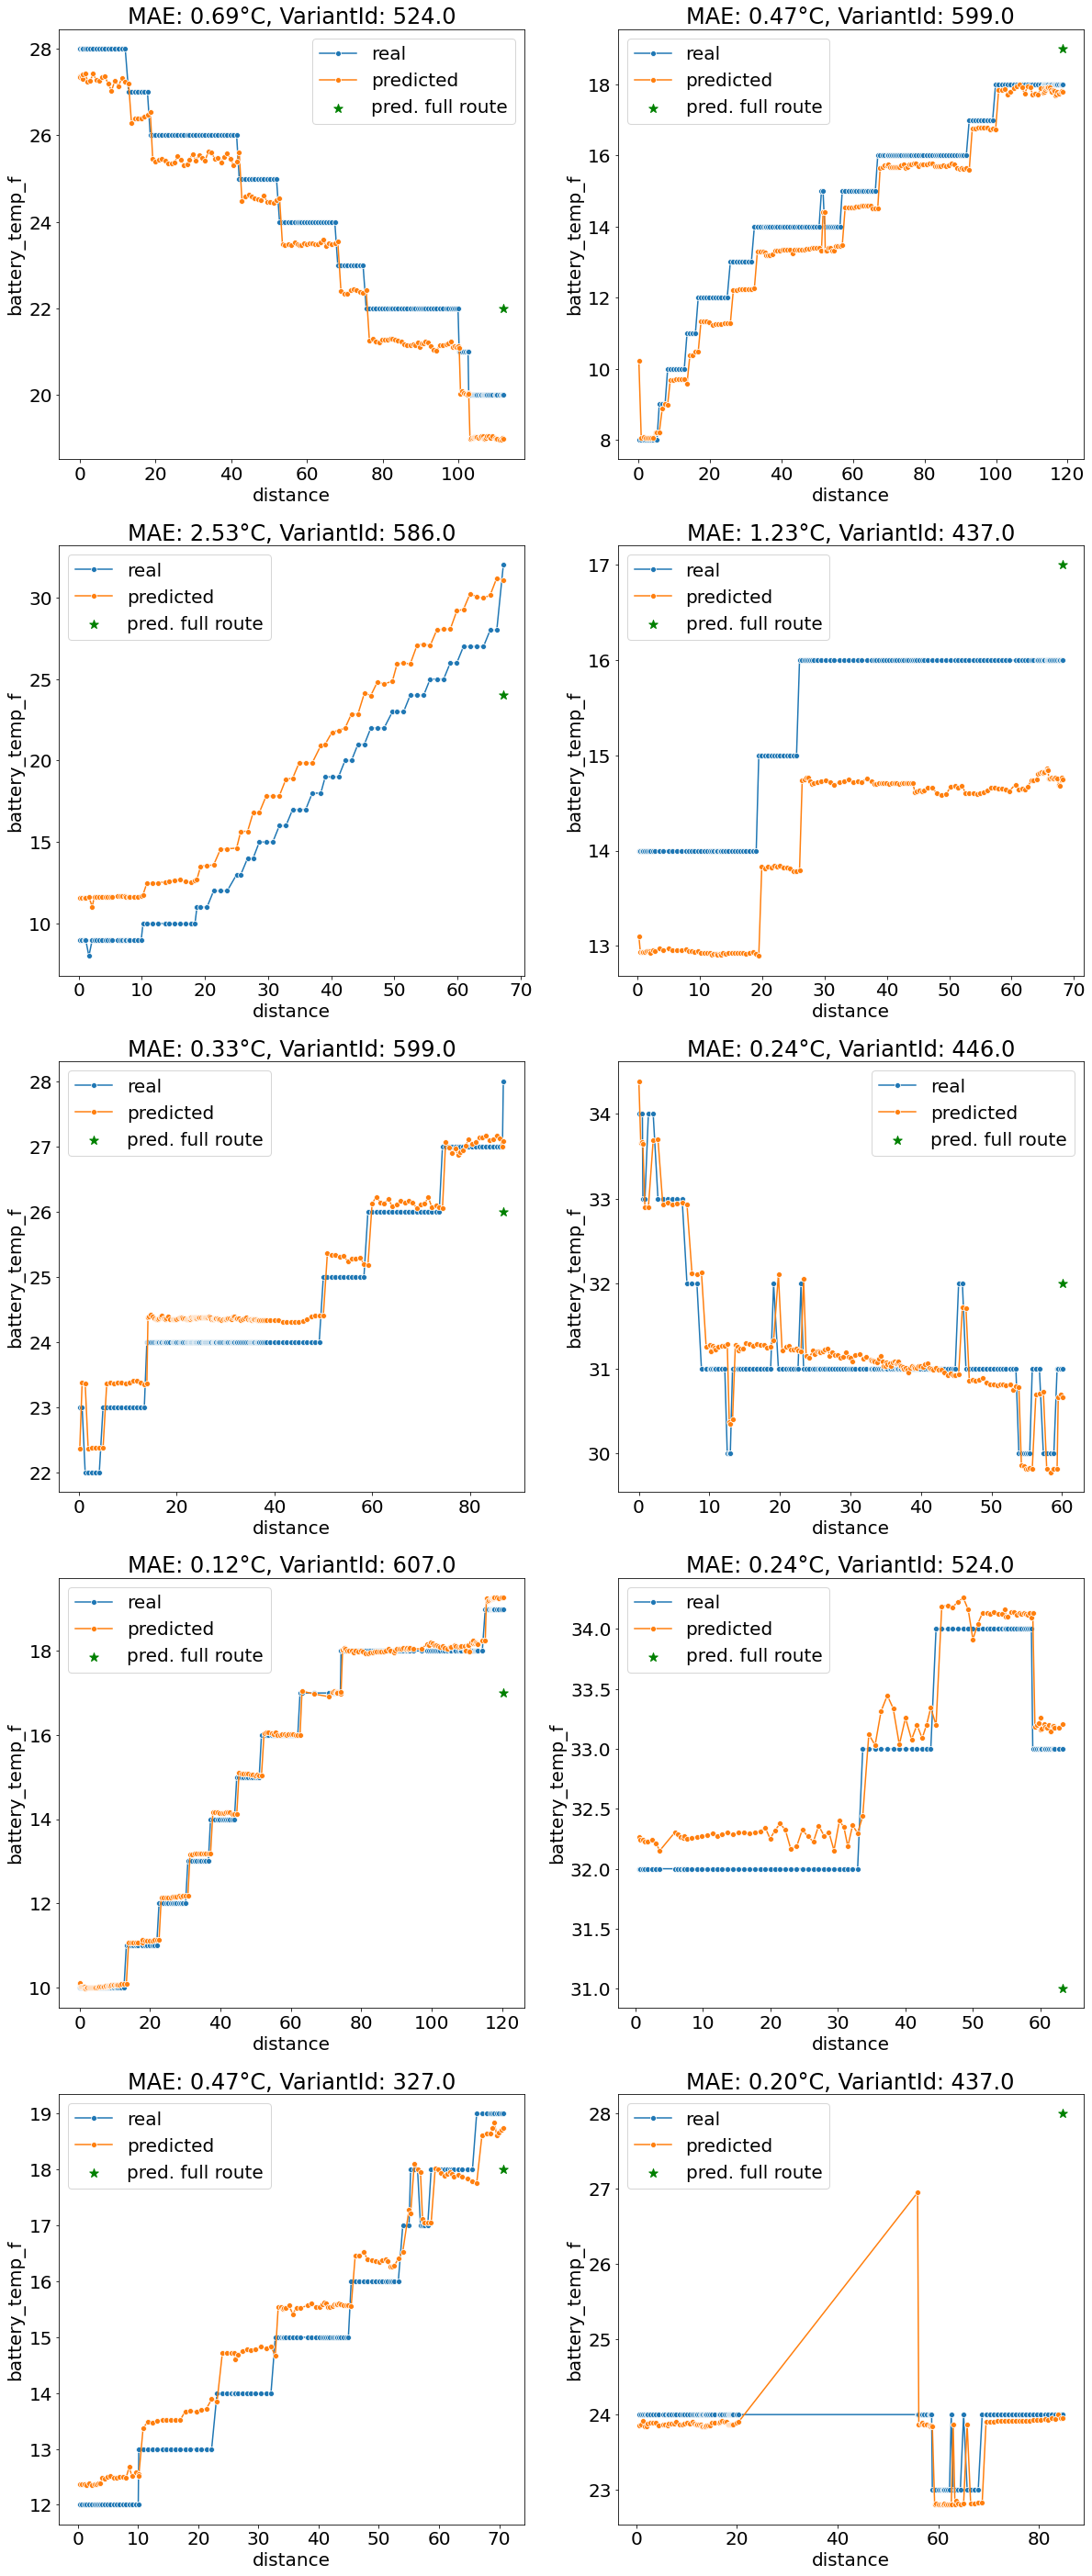

In [41]:
drives = get_trip_data()

fig = plt.figure(figsize=(20,50));
plt.rc('font', size=20);
for i, drive in enumerate(drives):
    ax = fig.add_subplot(5,2,i+1);
    plot_check_with_real(drive, ax, mlp_hp_best);
    ax.legend();

The Figure above shows the battery temperature vs. traveled distance in km for randomly selected drives. The blue data shows the real data, whereas the orange one corresponds to the predicted values. On top of each figure it is also depicted the corresponding MAE and the *vehiclevariant_id*. As observed the predictions match pretty nicely the real data, we see also that for each drive, the MAE is mostly lower than 1°C.

### Conclusions

In this report we have used various drive data from electric vehicles and use them to predict the battery temperature during a drive event. We have shown that be introducing known initial parameters such as the initial battery temperature, the air temperature, initial SoC, the altitude difference and total drive distance we are able to predict what would be the battery temperature at the end of the drive event. Since charging processes are strongly dependent on the battery temperature at the beginning of the charge event, we can thus, use the battery prediction here developed to further select the proper charge curve, since we can in principle know at which temperature will the charging process start. 

## Appendix

1. Score values of models including time features such as *week* *month* as categorical features. 

In [46]:
# initial data
target_cols = [
    'battery_temp_f',    
]

feature_cols = [
#     'timestamp',
    'delta_altitude',
    'speed_av',
    'total_distance',
    'air_temp',
    'soc_i',
    'battery_temp_i',
    'week',
    "month",
    'vehiclevariant_id',
#     'consumptioncurve_id',
]

cat_cols = [
   "vehiclevariant_id",
    'week',
    "month",
#     "consumptioncurve_id",
]

selector_res_vvid_time = model_selector(
    data_cleaned, feature_cols, target_cols, cat_cols, "vehiclevariant_id")

text = "Table 3. Algorithm scores - Vehicle variant ID + time"
print(text, "\n"+"_"*len(text))
selector_res_vvid_time.head(10)

Table 3. Algorithm scores - Vehicle variant ID + time 
_____________________________________________________


MAE   RMSE  $r^2$                      model              scaler
0  1.121  1.921  0.942               MLPRegressor        power_scaler
0  1.120  1.936  0.942               MLPRegressor     standard_scaler
0  1.147  1.940  0.941               MLPRegressor  quantile_transform
0  1.141  1.969  0.940               MLPRegressor                None
0  1.106  2.004  0.937        ExtraTreesRegressor        power_scaler
0  1.106  2.004  0.937        ExtraTreesRegressor     standard_scaler
0  1.106  2.004  0.937        ExtraTreesRegressor                None
0  1.106  2.004  0.937        ExtraTreesRegressor  quantile_transform
0  1.153  2.022  0.936  GradientBoostingRegressor  quantile_transform
0  1.152  2.022  0.936  GradientBoostingRegressor     standard_scaler

2. Score values of models including time features such as *week* *month* as numerical features. 

In [43]:
# initial data
target_cols = [
    'battery_temp_f'    
]

feature_cols = [
#     'timestamp',
    'delta_altitude',
    'speed_av',
    'total_distance',
    'air_temp',
    'soc_i',
    'battery_temp_i',
    'week',
    "month",
    'vehiclevariant_id',
#     'consumptioncurve_id',
]

cat_cols = [
   "vehiclevariant_id",
#     "consumptioncurve_id",
]

selector_res_vvid_time = model_selector(
    data_cleaned, feature_cols, target_cols, cat_cols, "vehiclevariant_id")

text = "Table 3. Algorithm scores - Vehicle variant ID + time"
print(text, "\n"+"_"*len(text))
selector_res_vvid_time.head(10)

Table 3. Algorithm scores - Vehicle variant ID + time 
_____________________________________________________


MAE   RMSE  $r^2$                      model              scaler
0  1.100  1.885  0.945               MLPRegressor        power_scaler
0  1.095  1.886  0.945               MLPRegressor     standard_scaler
0  1.105  1.892  0.944               MLPRegressor  quantile_transform
0  1.132  1.968  0.940               MLPRegressor                None
0  1.097  1.990  0.938        ExtraTreesRegressor        power_scaler
0  1.097  1.990  0.938        ExtraTreesRegressor     standard_scaler
0  1.097  1.990  0.938        ExtraTreesRegressor                None
0  1.097  1.990  0.938        ExtraTreesRegressor  quantile_transform
0  1.150  2.020  0.936  GradientBoostingRegressor                None
0  1.150  2.020  0.936  GradientBoostingRegressor  quantile_transform

3. Score values of models including *odometer* feature. 

In [10]:
# initial data
target_cols = [
    'battery_temp_f'    
]

feature_cols = [
#     'timestamp',
    'delta_altitude',
    'speed_av',
    'total_distance',
    'air_temp',
    'soc_i',
    'battery_temp_i',
    'odometer',
    'vehiclevariant_id',
#     'consumptioncurve_id',
]

cat_cols = [
   "vehiclevariant_id",
#     "consumptioncurve_id",
]

selector_res_vvid_odometer = model_selector(
    data_cleaned, feature_cols, target_cols, cat_cols, "vehiclevariant_id")

text = "Table 3. Algorithm scores - Vehicle variant ID + Odometer"
print(text, "\n"+"_"*len(text))
selector_res_vvid_odometer.head(10)

Table 3. Algorithm scores - Vehicle variant ID + Odometer 
_________________________________________________________


MAE   RMSE  $r^2$                      model              scaler
0  1.080  1.876  0.945               MLPRegressor  quantile_transform
0  1.069  1.877  0.945               MLPRegressor     standard_scaler
0  1.077  1.880  0.945               MLPRegressor        power_scaler
0  1.097  1.996  0.938        ExtraTreesRegressor        power_scaler
0  1.097  1.996  0.938        ExtraTreesRegressor     standard_scaler
0  1.097  1.996  0.938        ExtraTreesRegressor                None
0  1.097  1.996  0.938        ExtraTreesRegressor  quantile_transform
0  1.148  2.017  0.937  GradientBoostingRegressor  quantile_transform
0  1.148  2.017  0.937  GradientBoostingRegressor        power_scaler
0  1.148  2.018  0.937  GradientBoostingRegressor                None

4. Hyperparameter tunning functions

In [5]:
import re
def plot_params_score(data):
    regex= "(?<=__)(\w+)"
    par_names = [par for par in data.params.iloc[0]]
    nr_params = int(len(par_names))
    if nr_params == 2:
        nr_rows, nr_cols = 1, 2
    elif nr_params == 1:
        nr_rows, nr_cols = 1, 1
    elif nr_params == 3:
        nr_rows, nr_cols = 2, 2
    elif nr_params%2 == 0:
        nr_rows = nr_cols = nr_params//2
    else:
        nr_rows, nr_cols = nr_params//2 + 1, nr_params//2
    fig = plt.figure(figsize=(10, 7))
    for i, par in enumerate(par_names):
        try:
            x =  pd.to_numeric(data["param_"+par])
        except:
            x = data["param_"+par].astype(str)
        ax = fig.add_subplot(nr_rows, nr_cols, i+1)
        ax.plot(x , data["mean_test_score"], "o")
        ax.set_xlabel(re.search(regex, par)[0])
        ax.set_ylabel("score")
    fig.tight_layout()



In [16]:
feature_cols = [
    'delta_altitude',
    'speed_av',
    'total_distance',
    'air_temp',
    'soc_i',
    'battery_temp_i',
    'vehiclevariant_id',
]

X_train, X_test, y_train, y_test = do_train_test_split(
        data_cleaned, feature_cols, target_cols, "vehiclevariant_id")

# Hyperparams optimization for mlpregressor
param_grid = {
#     'mlpregressor__hidden_layer_sizes': [(20,50,20), (50,50,50), (50,20,50)],
#     'mlpregressor__hidden_layer_sizes': [100,(20,20), (50,50), (20,50), (50,20)],
#     'mlpregressor__hidden_layer_sizes':range(60,201, 10),
    'mlpregressor__hidden_layer_sizes':[120],
#     'mlpregressor__max_iter': range(400, 1501, 100),
    'mlpregressor__max_iter': [500],
#     'mlpregressor__max_iter': range(200, 1001, 100),
    'mlpregressor__beta_1': [0.9],
    'mlpregressor__beta_2': [0.7],
#     'mlpregressor__beta_1': np.linspace(0.1,0.9, 9),
#     'mlpregressor__beta_2': np.linspace(0.1,0.9, 9),
#     'mlpregressor__activation': ['relu','tanh', "logistic"],
    'mlpregressor__activation': ["logistic"],
#     'mlpregressor__alpha': np.geomspace(1e-5,1,6),
#    'mlpregressor__learning_rate': ['constant','adaptive'],
}

# Create a based model
mlp_hp = setup_models_one_hot(cat_cols, scaler="standard_scaler")["MLPRegressor"]

# Instantiate the grid search model
mlp_grid_search = RandomizedSearchCV(estimator=mlp_hp,
                                     param_distributions=param_grid,
                                     cv=skf.split(X_train, X_train["vehiclevariant_id"]),
                                     n_iter=150,
                                     n_jobs=-1,
                                     random_state=42,
                                     verbose=True)

mlp_grid_search.fit(X_train, y_train.values.ravel());

Fitting 3 folds for each of 9 candidates, totalling 27 fits


/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jehamann/.local/lib/python3.8/site-pac

{'mlpregressor__max_iter': 500, 'mlpregressor__hidden_layer_sizes': 120, 'mlpregressor__beta_2': 0.7, 'mlpregressor__beta_1': 0.9, 'mlpregressor__activation': 'logistic'} 0.9411955480203309


/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(


Table . MLP. metrics before and after fine tuning.


MAE   RMSE  $r^2$
Optimization                     
before        1.053  1.868  0.946
after         1.041  1.867  0.946

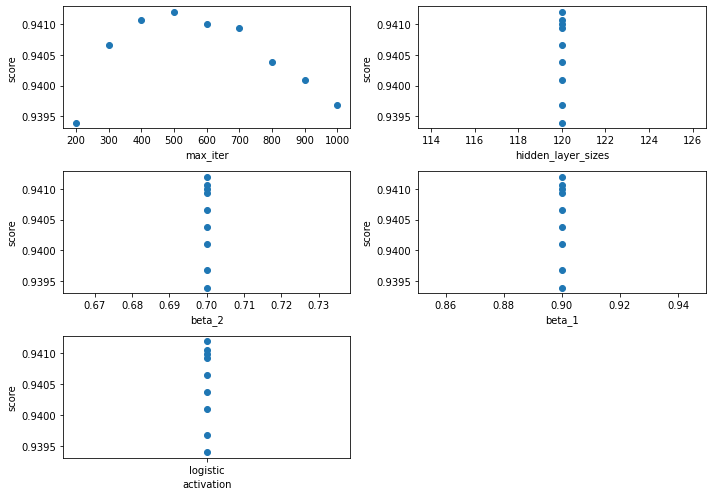

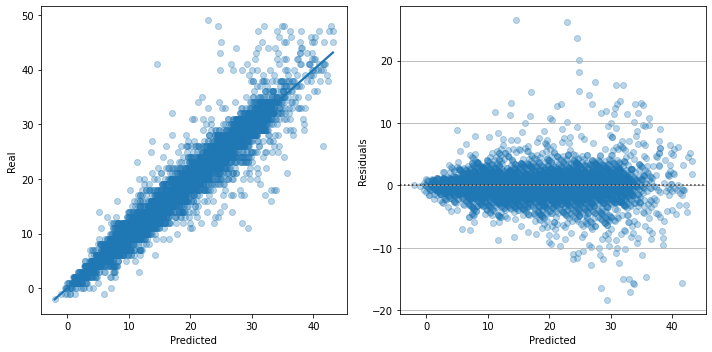

/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jehamann/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jehamann/.local/lib/python3.8/site-pac

In [17]:
print(mlp_grid_search.best_params_, mlp_grid_search.best_score_)

mlp_hp_best = mlp_grid_search.best_estimator_

base_model = setup_models_one_hot(
    cat_cols, scaler="standard_scaler")["MLPRegressor"]
base_model.fit(X_train, y_train)

mlp_before = evaluate_model(base_model, X_test, y_test)
mlp_before["Optimization"] = "before"

mlp_after = evaluate_model(mlp_hp_best, X_test, y_test)
mlp_after["Optimization"] = "after"

grid_res = pd.DataFrame(mlp_grid_search.cv_results_)
plot_params_score(grid_res)

plt.rc('font', size=10)
plot_residuals(mlp_hp_best, X_test, y_test.values.reshape(-1), hue=None);

print("Table . MLP. metrics before and after fine tuning.")
pd.concat([mlp_before, mlp_after]).set_index("Optimization")

In [18]:
plt.plot(mlp_hp_best[1].loss_curve_)
plt.yscale('log')
plt.xscale('log')
plt.ylim(0,4)


(1.3609429925479037, 4)

In [ ]:
def get_nr_layers(ni, no, ns, a=5):
    """
    Estimates the upper bound of the number of neurons to use in a hidden layer
    
    Parameters:
        ni : Number of input neurones (features)
        no : Number of output neurones (target)
        ns: Number of training sample
        a : scaling factor, between 2 and 10
    """
    return round(ns / (a * (ni +no)))